In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import torch, torchvision
print("torch:", torch.__version__)
print("CUDA toolkit:", torch.version.cuda)
print("GPU available:", torch.cuda.is_available())
print("torchvision:", torchvision.__version__)
print(torch.backends.cudnn.version())

torch: 0.3.1
CUDA toolkit: 9.0.176
GPU available: True
torchvision: 0.2.1
7005


In [3]:
from fastai.conv_learner import*
from fastai.dataset import*

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects


In [4]:
torch.cuda.set_device(0)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [5]:
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py widgetsnbextension --sys-prefix


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [6]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("CUDA device name:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: Tesla T4


In [7]:
PATH = Path('../data/pascal_2007')
list(PATH.iterdir())

[PosixPath('../data/pascal_2007/models'),
 PosixPath('../data/pascal_2007/segmentation'),
 PosixPath('../data/pascal_2007/test'),
 PosixPath('../data/pascal_2007/test.csv'),
 PosixPath('../data/pascal_2007/test.json'),
 PosixPath('../data/pascal_2007/tmp'),
 PosixPath('../data/pascal_2007/train'),
 PosixPath('../data/pascal_2007/train.csv'),
 PosixPath('../data/pascal_2007/train.json'),
 PosixPath('../data/pascal_2007/valid.json')]

In [8]:
trn_j = json.load((PATH/'train.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [9]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [10]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [11]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

In [12]:
FILENAME, ID, IMG_ID, CAT_ID,BBOX = 'file_name', 'id', 'image_id','category_id', 'bbox'

In [13]:
cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])
trn_fns = dict((o[ID], o[FILENAME]) for o in trn_j[IMAGES])
trn_ids = [o[ID] for o in trn_j[IMAGES]] 

In [91]:
#JPEGS= PATH/'train'

In [15]:
IMG_PATH = Path('../data/pascal_2007/train')
#IMG_PATH = Path(JPEGS)
list(IMG_PATH.iterdir())[:5]

[PosixPath('../data/pascal_2007/train/000005.jpg'),
 PosixPath('../data/pascal_2007/train/000007.jpg'),
 PosixPath('../data/pascal_2007/train/000009.jpg'),
 PosixPath('../data/pascal_2007/train/000012.jpg'),
 PosixPath('../data/pascal_2007/train/000016.jpg')]

In [16]:
im0_d = trn_j[IMAGES][0]
im0_d[FILENAME], im0_d[ID]

('000012.jpg', 12)

In [17]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))
        
len(trn_anno)

2501

In [18]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [19]:
im0_a = im_a[0];im0_a

(array([ 96, 155, 269, 350]), 7)

In [20]:
cats[7]

'car'

In [21]:
trn_anno[17]
list(trn_anno)[:5]

[12, 17, 23, 26, 32]

In [22]:
cats[15],cats[13]

('person', 'horse')

In [23]:

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [24]:
im = open_image(IMG_PATH/im0_d[FILENAME])

In [25]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [26]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [27]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [28]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

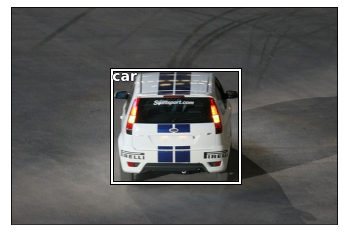

In [29]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [30]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [31]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(281, 500, 3)


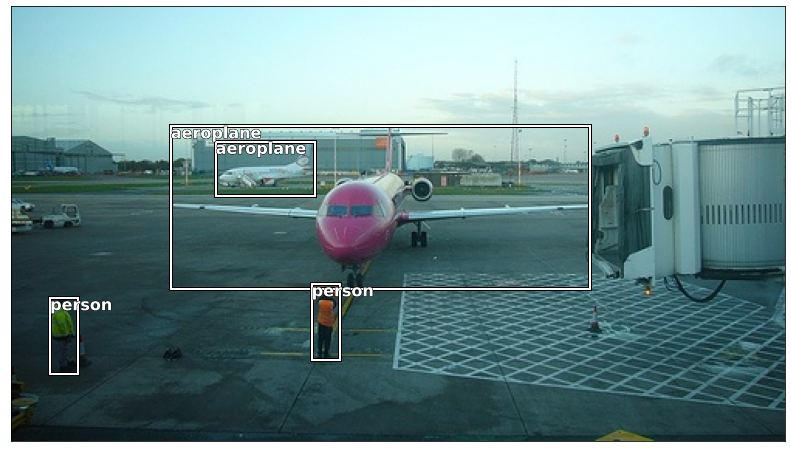

In [32]:
draw_idx(32)

### Step 1. Largest item classifier

In [33]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [34]:
trn_lrg_anno = {a: get_lrg(b) for a, b in trn_anno.items()}

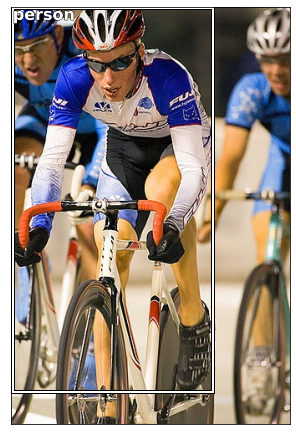

In [35]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [36]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV= PATH/'tmp/lrg.csv'

In [37]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                  'cat' : [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [38]:
f_model = resnet34
sz=224
bs=64

In [39]:
trn_IMG_PATH = 'train'

In [40]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, CSV, tfms=tfms)

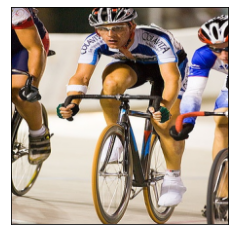

In [41]:
x, y = next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [42]:
learn = ConvLearner.pretrained(f_model, md, metrics = [accuracy])
learn.opt_fn = optim.Adam

In [44]:
lrf = learn.lr_find(1e-5, 100)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

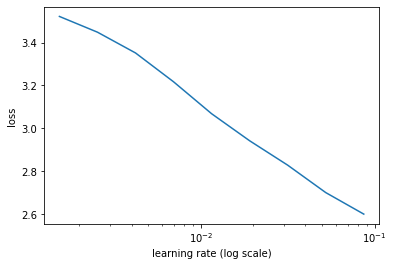

In [45]:
learn.sched.plot()

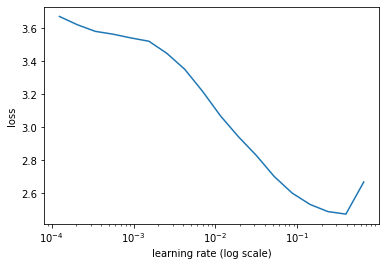

In [46]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [47]:
lr = 2e-2

In [48]:
learn.fit(lr, 1, cycle_len=1)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                 
    0      1.301441   0.657774   0.802     


[array([0.65777]), 0.8019999976158142]

In [49]:
lrs = np.array([lr/100,lr/100,lr])

In [50]:
learn.freeze_to(-2)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

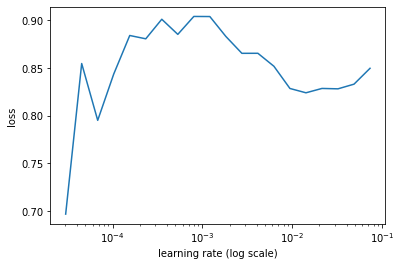

In [51]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [52]:
learn.fit(lrs/5,1,cycle_len=1)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                  
    0      0.790684   0.590486   0.822     


[array([0.59049]), 0.8220000023841858]

In [53]:
learn.unfreeze()

In [54]:
learn.fit(lrs/5, 1,cycle_len=2)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   accuracy                  
    0      0.628782   0.560578   0.838     
    1      0.446378   0.557857   0.838                     


[array([0.55786]), 0.8379999980926514]

In [55]:
learn.save('class_one')

In [41]:
learn.load('class_one')

In [42]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


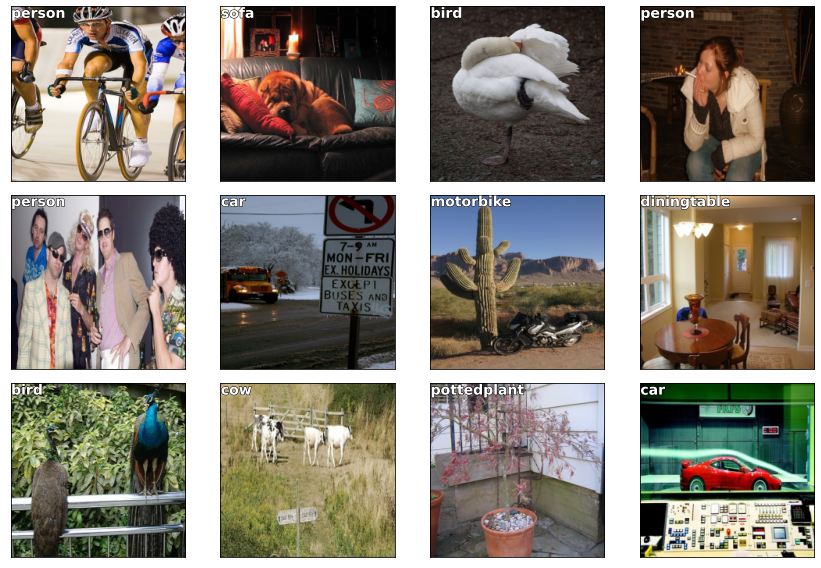

In [43]:
fig, axes = plt.subplots(3,4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

### BBOX

In [47]:
BB_CSV = PATH/'tmp/bb.csv'

In [48]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox':bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [49]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [50]:
f_model = resnet34
sz = 224
bs = 64

In [51]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, BB_CSV, tfms= tfms, continuous=True)

In [52]:
x, y = next(iter(md.val_dl))

In [53]:
ima = md.val_ds.denorm(to_np(x))[0]
b = bb_hw(to_np(y[0]));b

array([ 49.,   0., 131., 205.], dtype=float32)

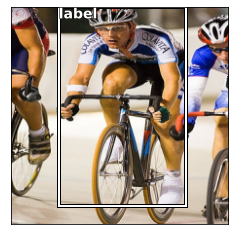

In [54]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], 'label')

In [55]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()


In [53]:
#learn.summary()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

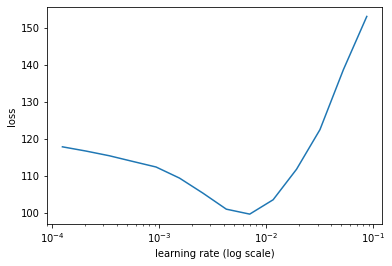

In [75]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [54]:
lr = 2e-3

In [77]:
learn.fit(lr, 2, cycle_len =1, cycle_mult=2)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch      trn_loss   val_loss                            
    0      49.383175  35.400256 
    1      37.475178  28.576222                           
    2      31.342143  27.798831                           


[array([27.79883])]

In [78]:
lrs = np.array([lr/100, lr/10,lr])

In [79]:
learn.freeze_to(-2)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

epoch      trn_loss   val_loss                            
    0      70.833954  1437624494985314.2


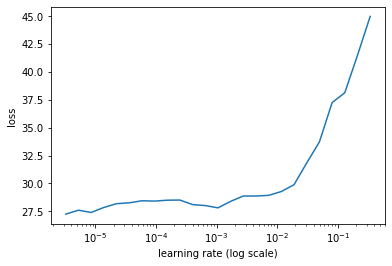

In [80]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [81]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch      trn_loss   val_loss                            
    0      26.26894   23.694976 
    1      21.916065  21.268519                           
    2      17.872967  20.575566                           


[array([20.57557])]

In [82]:
learn.freeze_to(-3)

In [83]:
learn.fit(lrs, 1, cycle_len=2)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

epoch      trn_loss   val_loss                            
    0      15.622747  21.653855 
    1      14.400855  20.345284                           


[array([20.34528])]

In [84]:
learn.save('reg4')

In [85]:
learn.load('reg4')

In [88]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


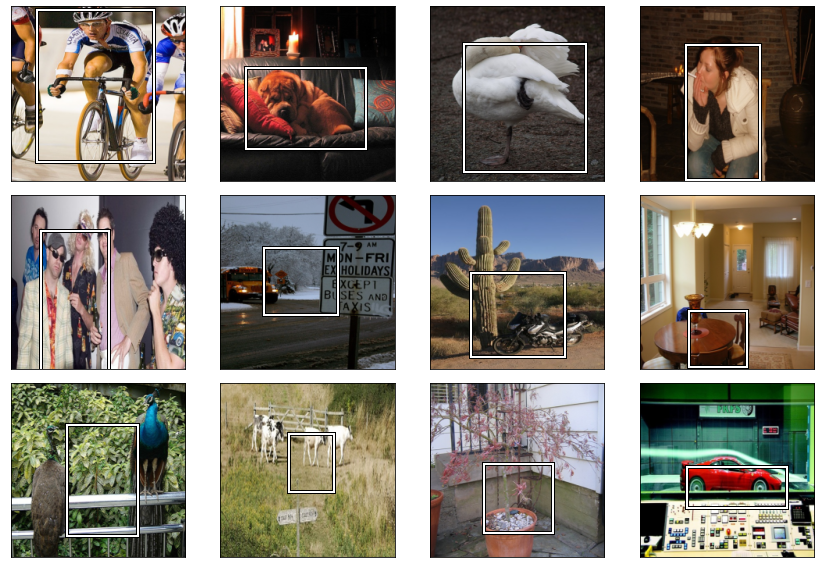

In [89]:
fig, axes = plt.subplots(3,4, figsize = (12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(to_np(x))[i]
    b =bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

### Aug

In [56]:
f_model = resnet34
sz= 224
bs =64

In [57]:
augs = [RandomFlip(),
       RandomRotate(30),
       RandomLighting(0.1, 0.1)]

In [58]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms = augs)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, BB_CSV, tfms=tfms, continuous=True, bs=4)

[115.  63. 240. 311.]
[115.  63. 240. 311.]
[115.  63. 240. 311.]
[115.  63. 240. 311.]
[115.  63. 240. 311.]
[115.  63. 240. 311.]
[115.  63. 240. 311.]
[115.  63. 240. 311.]
[115.  63. 240. 311.]


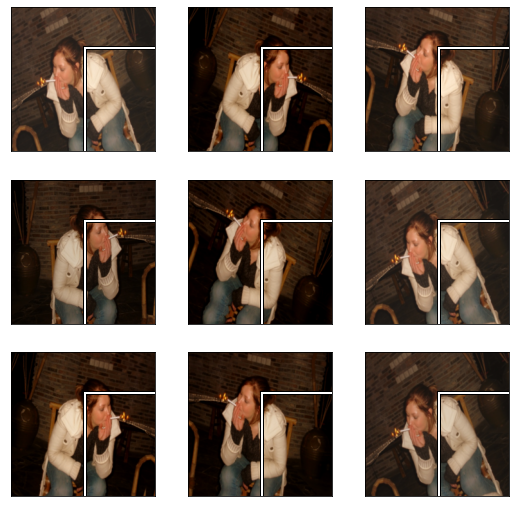

In [59]:
idx = 3
fig, axes = plt.subplots(3,3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x,y = next(iter(md.aug_dl))
    ima = md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax,b)

In [60]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
       RandomRotate(30, tfm_y=TfmType.COORD),
       RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [61]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms = augs)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 50.  17. 143. 205.]
[ 46.  32. 115. 190.]
[ 66.  38. 104. 182.]
[ 45.  30. 124. 192.]
[ 34.  18. 155. 204.]
[ 66.  38. 104. 182.]
[ 52.  38. 105. 182.]
[ 25.  12. 150. 210.]
[ 25.  12. 150. 210.]


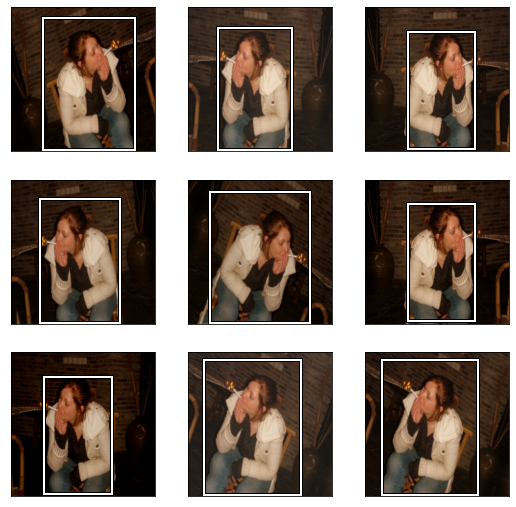

In [62]:
idx = 3
fig, axes = plt.subplots(3,3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x,y = next(iter(md.aug_dl))
    ima = md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax,b)

In [63]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
       RandomRotate(3, p=0.5, tfm_y=tfm_y),
       RandomLighting(0.05,0.05, tfm_y=tfm_y)]

In [64]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms = augs)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, BB_CSV, tfms=tfms, continuous=True)

### Single object detection

In [65]:
f_model = resnet34
sz = 224
bs =64

val_idxs = get_cv_idxs(len(trn_fns))

In [66]:
tfms = tfms_from_model(f_model, sz , crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms = augs)
md = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, BB_CSV, tfms=tfms,
                                  continuous=True, val_idxs=val_idxs)

In [67]:
md2 = ImageClassifierData.from_csv(PATH, trn_IMG_PATH, CSV, tfms= tfms_from_model(f_model,sz))

In [68]:
class ConcatLbDataset(Dataset):
    def __init__(self, ds, y2): self.ds, self.y2 = ds, y2
    def __len__(self): return len(self.ds)

    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [69]:
trn_ds2 = ConcatLbDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLbDataset(md.val_ds, md2.val_y)

In [70]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [71]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [72]:
x, y = next(iter(md.val_dl))
idx =3
ima = md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 106., 184.], dtype=float32)

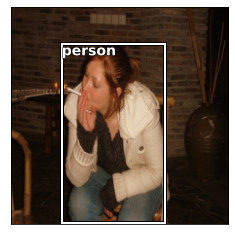

In [73]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [74]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4+len(cats)),
)

models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [75]:
def detn_loss(input, target):
    bb_t, c_t = target
    bb_i, c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_L1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _, c_t= target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_L1]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

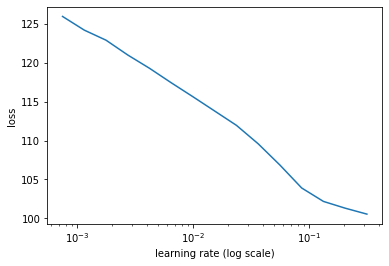

In [76]:
learn.lr_find()
learn.sched.plot()

In [77]:
lr = 1e-2

In [78]:
learn.fit(lr,1, cycle_len=3, use_clr=(32,5))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   detn_acc   detn_L1       
    0      72.29238   42.367606  0.792      29.59628  
    1      52.248425  36.637968  0.808      25.231747     
    2      43.60719   35.291561  0.83       24.511114     


[array([35.29156]), 0.8300000023841858, 24.51111372375488]

In [79]:
learn.save('reg1_0')

In [80]:
learn.freeze_to(-2)

In [81]:
lrs = np.array([lr/100, lr/10, lr])

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

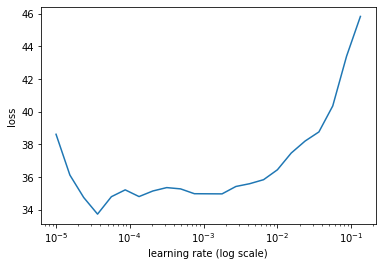

In [82]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [83]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr = (32,10))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   detn_acc   detn_L1       
    0      37.715852  35.01152   0.788      22.289367 
    1      32.052118  32.136907  0.834      21.402176     
    2      27.549945  30.348825  0.836      20.096206     
    3      24.081494  30.411497  0.83       19.531112     
    4      21.737302  30.122858  0.846      19.52091      


[array([30.12286]), 0.8460000009536743, 19.520909698486328]

In [84]:
learn.save('reg1_1')

In [85]:
learn.load('reg1_1')

In [86]:
learn.unfreeze()

In [87]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

epoch      trn_loss   val_loss   detn_acc   detn_L1       
    0      18.641863  30.182725  0.834      19.391729 
    1      18.2931    31.227204  0.816      19.675155     
    2      17.670659  29.785064  0.852      19.073776     
    3      16.895258  31.099555  0.834      19.383413     
    4      15.986733  30.201906  0.852      18.984388     
    5      15.327695  30.282528  0.838      18.643194     
    6      14.404434  29.533827  0.846      18.605192     
    7      13.672816  29.348078  0.838      18.138914     
    8      13.132849  29.399487  0.84       18.316244     
    9      12.811785  29.406241  0.836      18.14707      


[array([29.40624]), 0.8360000023841858, 18.147070236206055]

In [88]:
learn.save('reg1')

In [93]:
learn.load('reg1')

In [94]:
y = learn.predict()
x,_ = next(iter(md.val_dl))
x = to_np(x)